In [4]:
import pandas as pd
import xarray as xr
from statsmodels.iolib.smpickle import load_pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


dwd_Hornsea1 = xr.open_dataset("/Users/narutakanomura/Desktop/local_compe/local_Getting Started/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"].dt.tz_localize("UTC")
dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")

dwd_solar = xr.open_dataset("/Users/narutakanomura/Desktop/local_compe/local_Getting Started/dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar_features = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features["ref_datetime"] = dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

energy_data = pd.read_csv("/Users/narutakanomura/Desktop/local_compe/local_Getting Started/Energy_Data_20200920_20231027.csv")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]

modelling_table = dwd_Hornsea1_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]
modelling_table.rename(columns={"WindSpeed:100":"WindSpeed"},inplace=True)

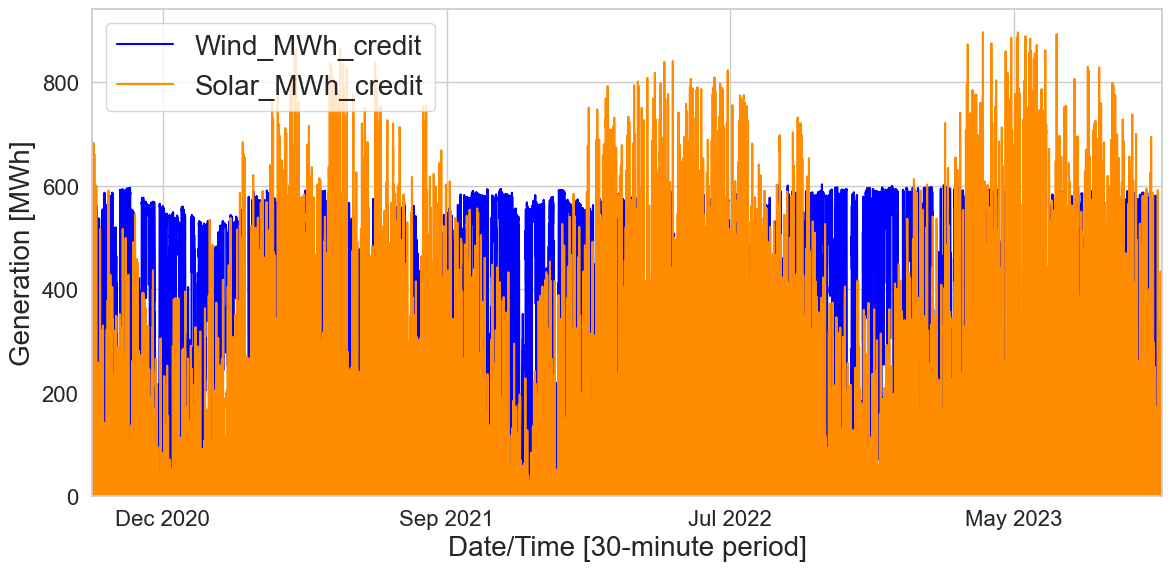

In [9]:
plt.figure(figsize=(12,6))
sns.set(style='whitegrid')
sns.color_palette("pastel", as_cmap=True)
ax2 = sns.lineplot(data=energy_data, x="dtm", y="Wind_MWh_credit",
                   label='Wind_MWh_credit', color='blue')
ax1 = sns.lineplot(data=energy_data, x="dtm", y="Solar_MWh_credit",
                   label='Solar_MWh_credit', color="darkorange")

# X軸とY軸のメモリのフォントサイズを16に設定
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlim(left=energy_data['dtm'].min(), right=energy_data['dtm'].max())
ax1.set_ylim(0)
#plt.title("Generation", loc='left', fontsize=20)
plt.rcParams.update({'font.size': 16})
plt.xlabel("Date/Time [30-minute period]", fontsize=20)
plt.ylabel("Generation [MWh]", fontsize=20)
ax1.legend(loc='best', fontsize=20)
plt.tight_layout()

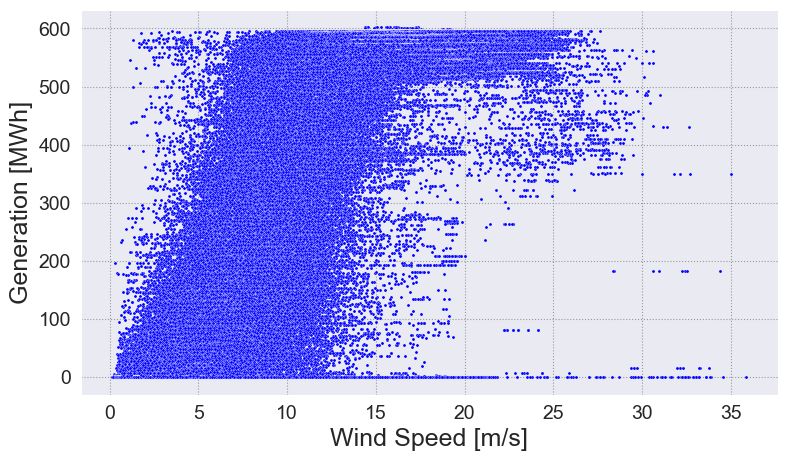

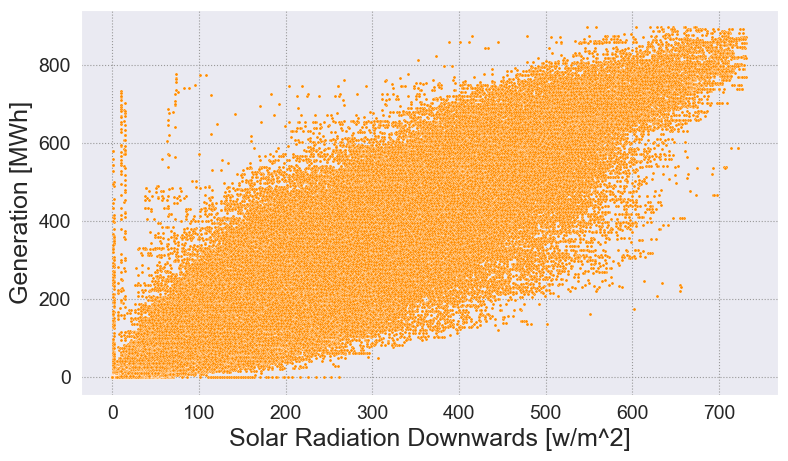

In [8]:
# 最初の散布図
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=modelling_table, x="WindSpeed", y="Wind_MWh_credit",
                color='blue', s=5)
plt.xlabel('Wind Speed [m/s]', fontsize=18)
plt.ylabel('Generation [MWh]', fontsize=18)

# メモリのフォントサイズを16に設定
plt.tick_params(axis='both', labelsize=14)

# 次の散布図
plt.figure(figsize=(9,5))
sns.scatterplot(data=modelling_table, x="SolarDownwardRadiation", 
                y="Solar_MWh_credit", color='darkorange', s=5)
plt.xlabel('Solar Radiation Downwards [w/m^2]', fontsize=18)
plt.ylabel('Generation [MWh]', fontsize=18)

# こちらのメモリのフォントサイズも16に設定
plt.tick_params(axis='both', labelsize=14)